# Segmentation and Detection with PaliGemma 🤗

PaliGemma is a new vision language model released by Google. In this notebook, we will see how to use PaliGemma for segmentation and detection.
Make sure to install transformers from main and restart your kernel.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.9 MB/s eta 0:00:00


PaliGemma requires users to accept Gemma license, so make sure to go to [the repository]() and ask for access. If you have previously accepted Gemma license, you will have access to this model as well. Once you have the access, login to Hugging Face Hub using `notebook_login()` and pass your access token by running the cell below.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

PaliGemma mix checkpoints are essentially PaliGemma pretrained models finetuned on a variety of benchmark datasets. If you want to use PaliGemma for segmentation or detection simply pass "segment object1 ; object2 ; object3" for objects you want to segment or prepend with "detect" to detect.

In [ ]:
import torch
import numpy as np
from PIL import Image
import requests

input_text = "segment bird ; plant"
img_url = "https://huggingface.co/spaces/google/paligemma-hf/resolve/main/bird.jpg?download=true"
input_image = Image.open(requests.get(img_url, stream=True).raw)

The image looks like below.

![](https://huggingface.co/spaces/google/paligemma-hf/resolve/main/bird.jpg?download=true)

You can load PaliGemma model and processor like below.

In [ ]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float16)
processor = PaliGemmaProcessor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

The processor preprocesses both the image and text, so we will pass them.

In [ ]:
inputs = processor(text=input_text, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")
model.to(device)
inputs = inputs.to(dtype=model.dtype)


We can pass in our preprocessed inputs.

In [ ]:
with torch.no_grad():
  output = model.generate(**inputs, max_length=496)

print(processor.decode(output[0], skip_special_tokens=True)[len(input_text):].lstrip("\n"))

<loc0232><loc0000><loc0412><loc0329> <seg078><seg014><seg041><seg008><seg057><seg065><seg093><seg043><seg079><seg101><seg116><seg040><seg050><seg075><seg121><seg108> plant ; <loc0681><loc0487><loc0774><loc0606> <seg044><seg059><seg074><seg012><seg010><seg087><seg078><seg057><seg035><seg012><seg043><seg061><seg074><seg012><seg109><seg005> bird


This is not very human readable. The authors have trained a separate model to decode these tokens into segmentation masks, so we will download the model, extract the "numbers" from these tokens and pass them inside the network and it will return the masks. This model is in JAX, don't worry if you don't understand since we just need to infer.

In [ ]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="google/paligemma-hf", filename="vae-oid.npz",
                repo_type="space", local_dir="./")

'vae-oid.npz'

Helper functions are below.

In [ ]:
import re
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import functools
import PIL

_MODEL_PATH = 'vae-oid.npz'

_SEGMENT_DETECT_RE = re.compile(
    r'(.*?)' +
    r'<loc(\d{4})>' * 4 + r'\s*' +
    '(?:%s)?' % (r'<seg(\d{3})>' * 16) +
    r'\s*([^;<>]+)? ?(?:; )?',
)


def _get_params(checkpoint):

  def transp(kernel):
    return np.transpose(kernel, (2, 3, 1, 0))

  def conv(name):
    return {
        'bias': checkpoint[name + '.bias'],
        'kernel': transp(checkpoint[name + '.weight']),
    }

  def resblock(name):
    return {
        'Conv_0': conv(name + '.0'),
        'Conv_1': conv(name + '.2'),
        'Conv_2': conv(name + '.4'),
    }

  return {
      '_embeddings': checkpoint['_vq_vae._embedding'],
      'Conv_0': conv('decoder.0'),
      'ResBlock_0': resblock('decoder.2.net'),
      'ResBlock_1': resblock('decoder.3.net'),
      'ConvTranspose_0': conv('decoder.4'),
      'ConvTranspose_1': conv('decoder.6'),
      'ConvTranspose_2': conv('decoder.8'),
      'ConvTranspose_3': conv('decoder.10'),
      'Conv_1': conv('decoder.12'),
  }


def _quantized_values_from_codebook_indices(codebook_indices, embeddings):
  batch_size, num_tokens = codebook_indices.shape
  assert num_tokens == 16, codebook_indices.shape
  unused_num_embeddings, embedding_dim = embeddings.shape

  encodings = jnp.take(embeddings, codebook_indices.reshape((-1)), axis=0)
  encodings = encodings.reshape((batch_size, 4, 4, embedding_dim))
  return encodings


@functools.cache
def _get_reconstruct_masks():
  """Reconstructs masks from codebook indices.
  Returns:
    A function that expects indices shaped `[B, 16]` of dtype int32, each
    ranging from 0 to 127 (inclusive), and that returns a decoded masks sized
    `[B, 64, 64, 1]`, of dtype float32, in range [-1, 1].
  """

  class ResBlock(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
      original_x = x
      x = nn.Conv(features=self.features, kernel_size=(3, 3), padding=1)(x)
      x = nn.relu(x)
      x = nn.Conv(features=self.features, kernel_size=(3, 3), padding=1)(x)
      x = nn.relu(x)
      x = nn.Conv(features=self.features, kernel_size=(1, 1), padding=0)(x)
      return x + original_x

  class Decoder(nn.Module):
    """Upscales quantized vectors to mask."""

    @nn.compact
    def __call__(self, x):
      num_res_blocks = 2
      dim = 128
      num_upsample_layers = 4

      x = nn.Conv(features=dim, kernel_size=(1, 1), padding=0)(x)
      x = nn.relu(x)

      for _ in range(num_res_blocks):
        x = ResBlock(features=dim)(x)

      for _ in range(num_upsample_layers):
        x = nn.ConvTranspose(
            features=dim,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding=2,
            transpose_kernel=True,
        )(x)
        x = nn.relu(x)
        dim //= 2

      x = nn.Conv(features=1, kernel_size=(1, 1), padding=0)(x)

      return x

  def reconstruct_masks(codebook_indices):
    quantized = _quantized_values_from_codebook_indices(
        codebook_indices, params['_embeddings']
    )
    return Decoder().apply({'params': params}, quantized)

  with open(_MODEL_PATH, 'rb') as f:
    params = _get_params(dict(np.load(f)))

  return jax.jit(reconstruct_masks, backend='cpu')

def extract_objs(text, width, height, unique_labels=False):
  """Returns objs for a string with "<loc>" and "<seg>" tokens."""
  objs = []
  seen = set()
  while text:
    m = _SEGMENT_DETECT_RE.match(text)
    if not m:
      break
    gs = list(m.groups())
    before = gs.pop(0)
    name = gs.pop()
    y1, x1, y2, x2 = [int(x) / 1024 for x in gs[:4]]

    y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))
    seg_indices = gs[4:20]
    if seg_indices[0] is None:
      mask = None
    else:
      seg_indices = np.array([int(x) for x in seg_indices], dtype=np.int32)
      m64, = _get_reconstruct_masks()(seg_indices[None])[..., 0]
      m64 = np.clip(np.array(m64) * 0.5 + 0.5, 0, 1)
      m64 = PIL.Image.fromarray((m64 * 255).astype('uint8'))
      mask = np.zeros([height, width])
      if y2 > y1 and x2 > x1:
        mask[y1:y2, x1:x2] = np.array(m64.resize([x2 - x1, y2 - y1])) / 255.0

    content = m.group()
    if before:
      objs.append(dict(content=before))
      content = content[len(before):]
    while unique_labels and name in seen:
      name = (name or '') + "'"
    seen.add(name)
    objs.append(dict(
        content=content, xyxy=(x1, y1, x2, y2), mask=mask, name=name))
    text = text[len(before) + len(content):]

  if text:
    objs.append(dict(content=text))

  return objs

We can simply pass in the decoded PaliGemma output to `extract_objs` now.

In [ ]:
output = processor.decode(output[0], skip_special_tokens=True)

In [ ]:
output[len(input_text):].lstrip("\n")

'<loc0232><loc0000><loc0412><loc0329> <seg078><seg014><seg041><seg008><seg057><seg065><seg093><seg043><seg079><seg101><seg116><seg040><seg050><seg075><seg121><seg108> plant ; <loc0681><loc0487><loc0774><loc0606> <seg044><seg059><seg074><seg012><seg010><seg087><seg078><seg057><seg035><seg012><seg043><seg061><seg074><seg012><seg109><seg005> bird'

In [ ]:
width = input_image.size[0]
height = input_image.size[1]
masks = extract_objs(output[len(input_text):].lstrip("\n"), width, height)

In [ ]:
masks

[{'content': '<loc0232><loc0000><loc0412><loc0329> <seg078><seg014><seg041><seg008><seg057><seg065><seg093><seg043><seg079><seg101><seg116><seg040><seg050><seg075><seg121><seg108> plant ; ',
  'xyxy': (0, 176, 376, 312),
  'mask': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'name': 'plant '},
 {'content': '<loc0681><loc0487><loc0774><loc0606> <seg044><seg059><seg074><seg012><seg010><seg087><seg078><seg057><seg035><seg012><seg043><seg061><seg074><seg012><seg109><seg005> bird',
  'xyxy': (556, 516, 692, 587),
  'mask': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'name': '

Visualize plant and bird masks.

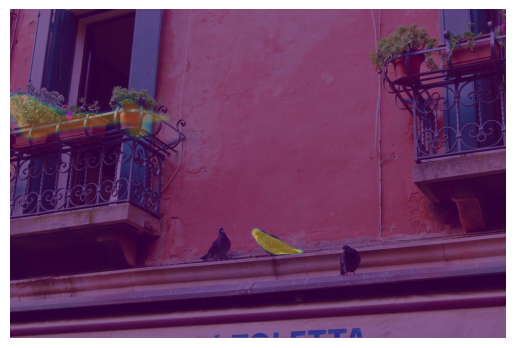

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(input_image, cmap='gray')

for i, mask in enumerate(masks):
    plt.imshow(mask["mask"], cmap='viridis', alpha=0.4, vmin=0, vmax=1)

plt.axis('off')
plt.show()